In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

def get_section_types(wav_names):
    section_types = []
    for wav_name in wav_names:
        if 'section_00' in wav_name:
            section_types.append(0)
        elif 'section_01' in wav_name:
            section_types.append(1)
        else:
            section_types.append(2)
    
    return section_types

section_types = get_section_types(wav_names)

# evaluation

## calc MVG (multivariate Gaussian)

In [10]:
MVG = {}
for machine_type in machine_types:
    com.tic()
    
    logger.info(f'====== Run {machine_type} ======')
    MVG[machine_type] = {}
    sc = StandardScaler()
    
    ext_data = load_ext_data(machine_type)['train']['features']
    ext_data = sc.fit_transform(ext_data)
    mean = ext_data.mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(ext_data)
    cov = cov_estimator.covariance_
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov
    MVG[machine_type]['sc'] = sc
    logger.info(f'====== Success {machine_type} ======')
    
    com.toc()

2021-03-25 23:51:03,598 - 00_train.py - INFO - ====== Run fan ======
2021-03-25 23:51:06,694 - 00_train.py - INFO - ====== Success fan ======
2021-03-25 23:51:06,694 - 00_train.py - INFO - ====== Run gearbox ======


elapsed time: 3.096460819 [sec]


2021-03-25 23:51:09,767 - 00_train.py - INFO - ====== Success gearbox ======
2021-03-25 23:51:09,767 - 00_train.py - INFO - ====== Run pump ======


elapsed time: 3.073173523 [sec]


2021-03-25 23:51:12,792 - 00_train.py - INFO - ====== Success pump ======
2021-03-25 23:51:12,793 - 00_train.py - INFO - ====== Run slider ======


elapsed time: 3.025085688 [sec]


2021-03-25 23:51:30,461 - 00_train.py - INFO - ====== Success slider ======
2021-03-25 23:51:30,462 - 00_train.py - INFO - ====== Run ToyCar ======


elapsed time: 17.669287920 [sec]


2021-03-25 23:51:33,828 - 00_train.py - INFO - ====== Success ToyCar ======
2021-03-25 23:51:33,829 - 00_train.py - INFO - ====== Run ToyTrain ======


elapsed time: 3.366694212 [sec]


2021-03-25 23:51:37,142 - 00_train.py - INFO - ====== Success ToyTrain ======
2021-03-25 23:51:37,143 - 00_train.py - INFO - ====== Run valve ======


elapsed time: 3.313956261 [sec]


2021-03-25 23:51:40,683 - 00_train.py - INFO - ====== Success valve ======


elapsed time: 3.541281939 [sec]


In [12]:
MVG[machine_type]['cov'].shape

(3072, 3072)

## estimate

2021-03-25 23:56:09,981 - 00_train.py - INFO - fan valid_source AUC : 0.5423222222222223
2021-03-25 23:56:09,983 - 00_train.py - INFO - fan valid_target AUC : 0.5454666666666667


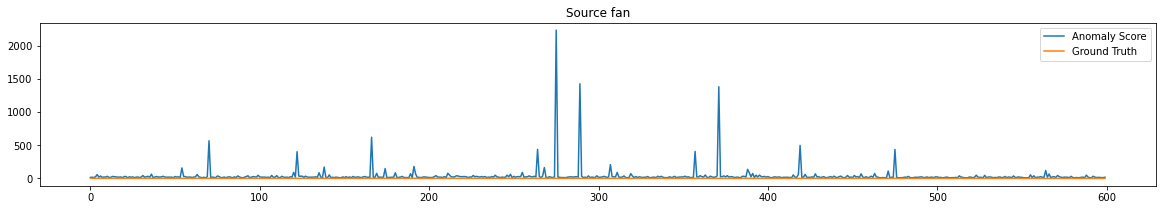

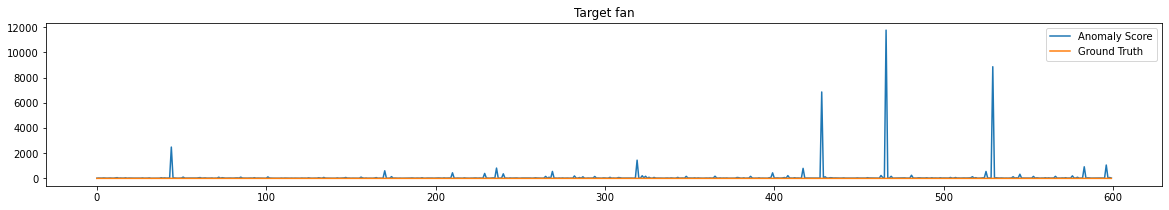

2021-03-25 23:56:14,438 - 00_train.py - INFO - gearbox valid_source AUC : 0.5803786193080598
2021-03-25 23:56:14,441 - 00_train.py - INFO - gearbox valid_target AUC : 0.6260402219140083


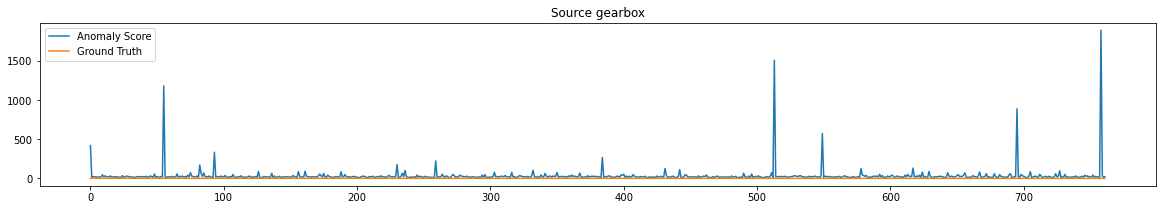

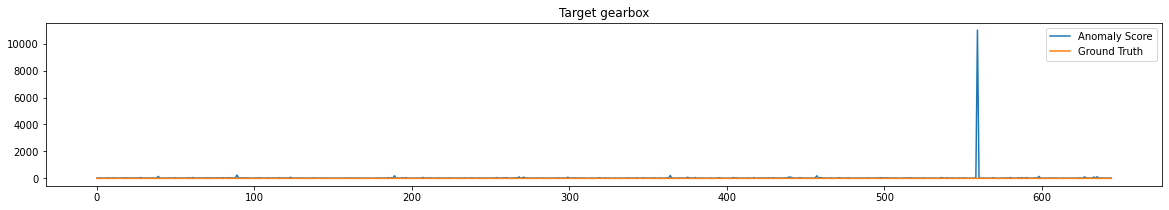

2021-03-25 23:56:18,266 - 00_train.py - INFO - pump valid_source AUC : 0.5948222222222223
2021-03-25 23:56:18,269 - 00_train.py - INFO - pump valid_target AUC : 0.5176333333333333


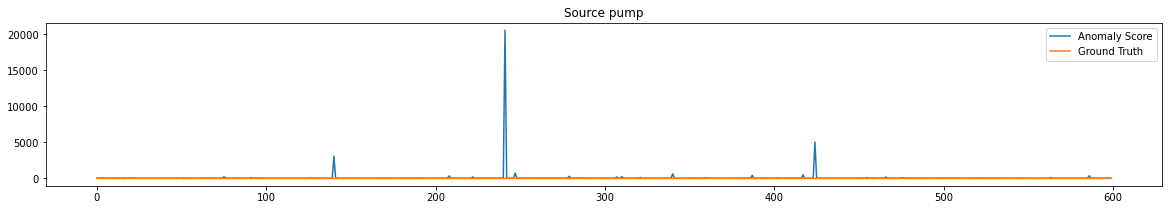

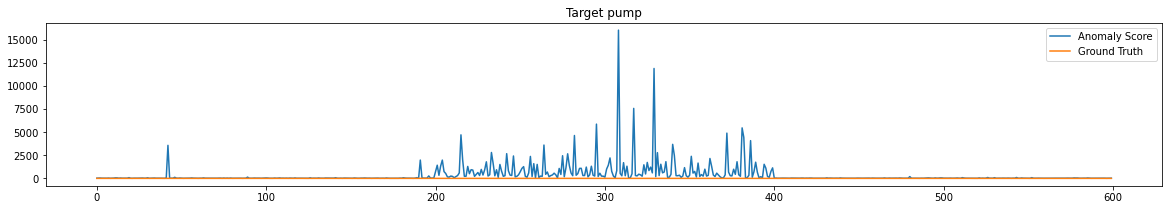

2021-03-25 23:56:22,100 - 00_train.py - INFO - slider valid_source AUC : 0.6772804956205939
2021-03-25 23:56:22,102 - 00_train.py - INFO - slider valid_target AUC : 0.6005518763796909


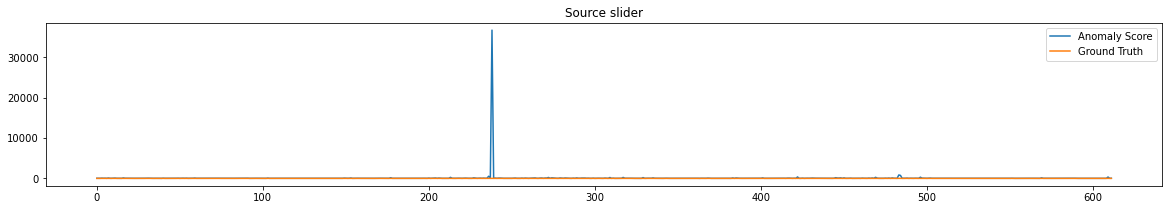

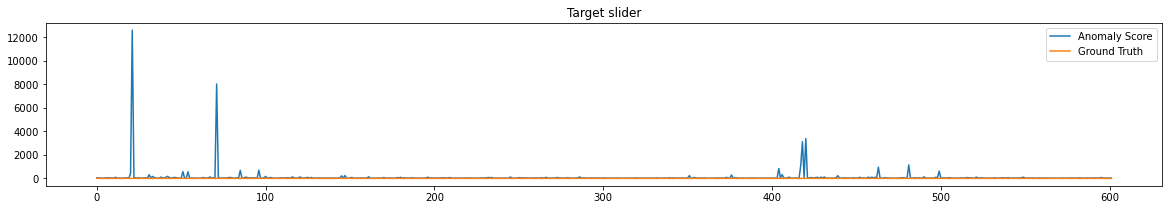

2021-03-25 23:56:26,037 - 00_train.py - INFO - ToyCar valid_source AUC : 0.5242555555555555
2021-03-25 23:56:26,039 - 00_train.py - INFO - ToyCar valid_target AUC : 0.526788888888889


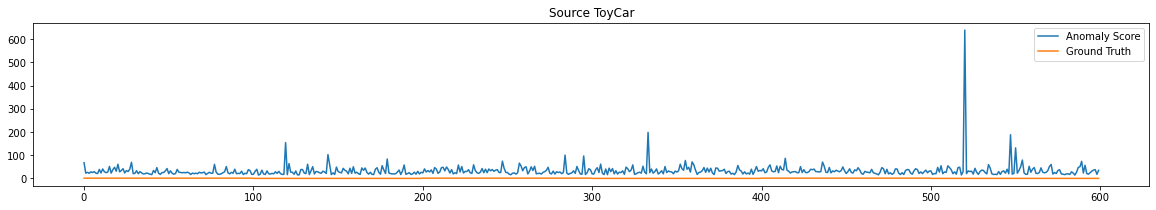

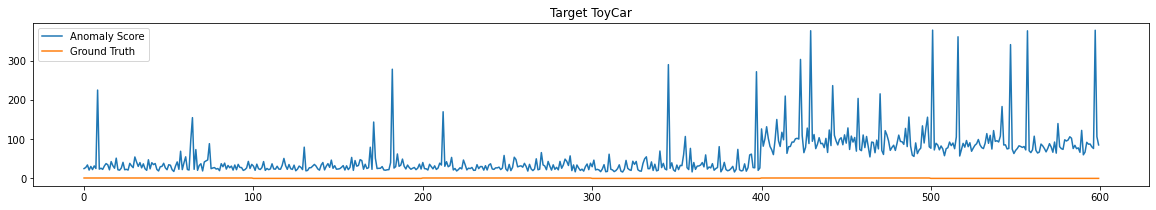

2021-03-25 23:56:30,090 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.5853333333333334
2021-03-25 23:56:30,092 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.4623555555555556


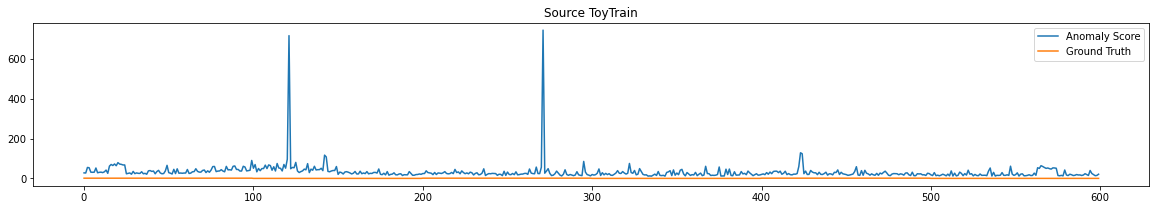

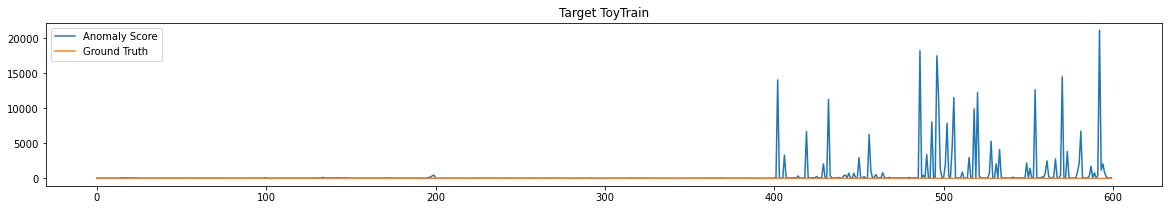

2021-03-25 23:56:34,344 - 00_train.py - INFO - valve valid_source AUC : 0.5280444444444443
2021-03-25 23:56:34,346 - 00_train.py - INFO - valve valid_target AUC : 0.4647444444444444


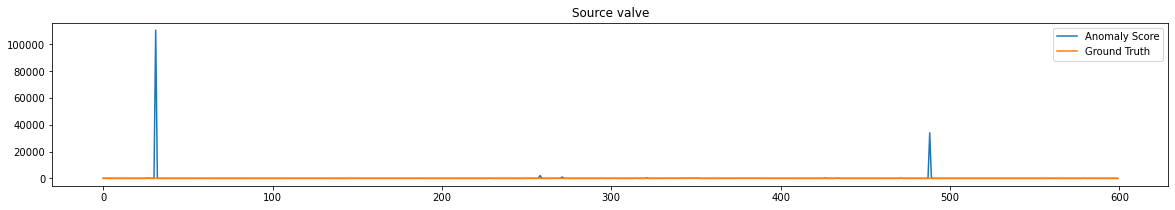

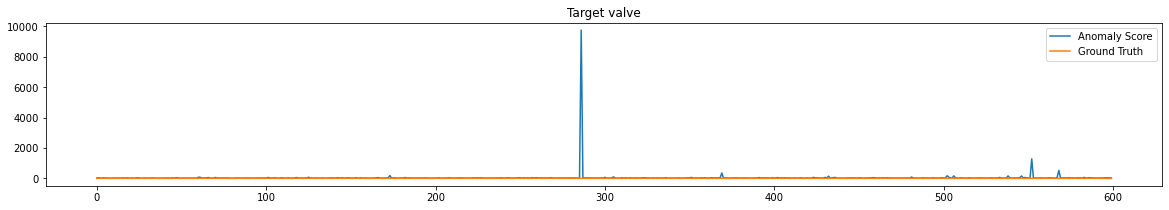

In [11]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # zscore
    #tr_data = MVG[machine_type]['sc'].transform(ext_data['train']['features'])
    val_source_data = MVG[machine_type]['sc'].transform(ext_data['valid_source']['features'])
    val_target_data = MVG[machine_type]['sc'].transform(ext_data['valid_target']['features'])
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in val_source_data]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in val_target_data]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [11]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [12]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

GaussianMixture(n_components=3, random_state=42)

In [16]:
gmm.bic(ext_data['train']['features'])

3319258.8933906704

In [22]:
pred = gmm.predict(ext_data['train']['features'])

(array([ 790.,    0.,    0.,    0.,    0.,  378.,    0.,    0.,    0.,
        1841.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

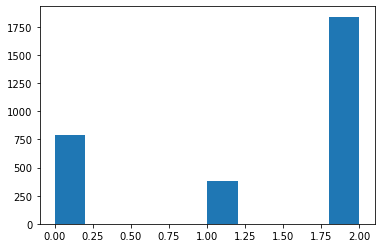

In [27]:
plt.hist(pred)

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [75]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [ ]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

In [71]:
gmm_section_types = gmm.predict(feats)

/home/hiroki/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

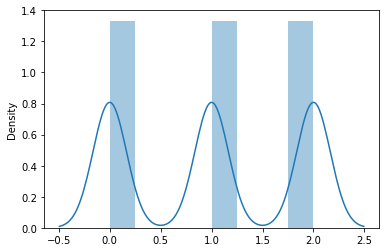

In [75]:
sns.distplot(section_types)

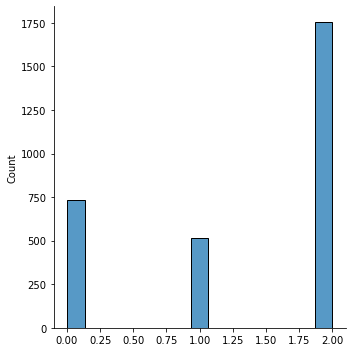

In [74]:
sns.displot(gmm_section_types)